In [2]:
# !pip install qutip
from qutip import *
from math import *
import itertools
from itertools import product
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

font = {'size'   : 17}

matplotlib.rc('font', **font)
# matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 6, 4
plt.rcParams['figure.dpi'] = 90
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
 

## Impurity Specific Heat

### 1. From Fermi liquid part of zero mode effective Hamiltonian with $k=0$

$$
C_v = \frac{1}{k_B T^2}\sum_{k\sigma}\frac{\epsilon_{k\sigma}^2 e^{\beta \epsilon_{k\sigma}}}{\left( 1 + e^{\beta\epsilon_{k\sigma}}\right)^2} - \frac{1}{k_B T^2}\sum_{k\sigma}\left[n_{k\sigma} + \frac{\beta\epsilon_{k\sigma} e^{\beta \epsilon_{k\sigma}}}{\left( 1 + e^{\beta\epsilon_{k\sigma}}\right)^2}\right]\frac{\partial \epsilon_{k\sigma}}{\partial \beta}
$$

-0.079631848728688


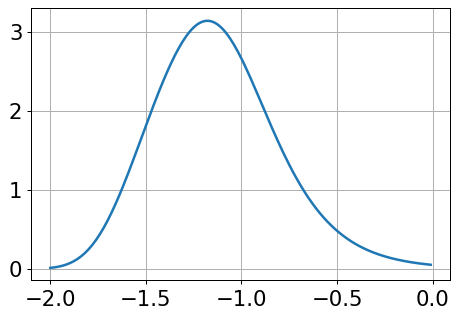

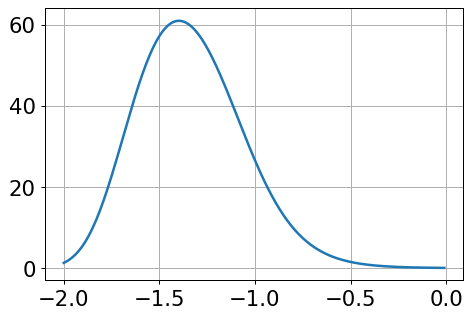

In [9]:
U       =  0
J       =  0.014671215288625387
K       =  0 # 0.04671215288625387
V       =  3.131196040544157
count   =  2
D       =  0.2

N = 2 * count
j = J * N
k = K * N
v = V * sqrt(N)

if v != 0:
    gamma = (3*j + k + 2*U)/(8*v)
    Eg = -U/2 - 3*j/4 + v * (gamma - sqrt(gamma*2 + 4))
else:
    Eg = -3*j/4

Ek_0 = np.array([-0.2, -0.1, 0.1, 0.2])

f = (J**2/(4*(Eg + J/4)**3) + K**2/(4*(Eg + K/4)**3) - 2*V**2/Eg**3)/(J**2/(4*(Eg + J/4)**2) + K**2/(4*(Eg + K/4)**2) - 2*V**2/Eg**2)
print (f)
Cv_imp = []
gamma = []
T_range = np.arange(-2, 0, 0.01)
for T in 10**T_range:
    kb = 1
    beta = 1/(kb * T)
    Ek_sigma_1 = Ek_0 + 2*f*Ek_0*sum(Ek_0/(1+np.exp(beta*Ek_0)))
    n_ksigma = 1/(1+np.exp(beta*Ek_sigma_1))
    Ek_sigma_0 = Ek_0 + 2*f*Ek_0*sum(Ek_0*n_ksigma)
    dn_ksigma = np.exp(beta*Ek_sigma_1) * (beta*2*f*Ek_0*sum(Ek_0**2 * np.exp(beta*Ek_0)/(1+np.exp(beta*Ek_0))**2) - Ek_sigma_1)/(1+np.exp(beta*Ek_sigma_1))**2
    Cv = 2*sum(Ek_sigma_0*dn_ksigma + n_ksigma*f*Ek_0*2*sum(Ek_0*dn_ksigma))/(-kb*T**2)
    Cv_0 = 2*sum(Ek_0*np.exp(beta*Ek_0)/((1+np.exp(beta*Ek_0))**2))/(-kb*T**2)
    Cv_imp.append(Cv - Cv_0)
    gamma.append(Cv_imp[-1]/T)

plt.plot(T_range, Cv_imp)
plt.show()
plt.plot(T_range, gamma)

### 2. From Fermi liquid part of zero mode effective Hamiltonian with $k=0$, interpreting RG flow as reduction in temperature

In [ ]:
U_arr = np.load("../spin-charge-symmetrical/U.npy")
J_arr = np.load("../spin-charge-symmetrical/J.npy")
K_arr = np.load("../spin-charge-symmetrical/K.npy")
V_arr = np.load("../spin-charge-symmetrical/V.npy")
count_arr = np.load("../spin-charge-symmetrical/count.npy")
D_arr = count_arr/10
Cv = []
Cvj = []
Cv_imp = []
for U,J,K,V,count,D in zip(U_arr, J_arr, K_arr, V_arr, count_arr, D_arr):
    # if count > 290:
    #     print (U,J,K,V,count,D)
    N = 2 * count
    # K = 0
    j = J * N
    v = V * sqrt(N)
    # k = 0
    gamma = (3*j + k + 2*U)/(8*v)
    Eg = -U/2 - 3*j/4 + v * (gamma - sqrt(gamma*2 + 4))
    # Eg = -1
    Ek = np.linspace(-D, D, N, endpoint=True)
    fk = ((J**2/(4*(Eg + J/4)**3) - 2*V**2/Eg**3)/(J**2/(4*(Eg + J/4)**2) - 2*V**2/Eg**2)) * Ek**2

    T = D
    fd = 1/(1 + np.exp(Ek/T))
    E = Ek + fk * fd
    Cj = 2 * sum(E * (2*E - Ek) / (fk/T + 2 * (np.cosh(E/(2*T)))**2)) / T**2
    C = 2 * sum(Ek**2 * np.exp(Ek/T)/((1 + np.exp(Ek/T))**2)) / T**2
    Cvj.append((Cj))
    Cv.append((C))
    Cv_imp.append(Cj - C)

plt.plot(D_arr, Cv_imp)
# plt.scatter(np.log10(Trange), np.array(Cv), color="y")
# plt.xscale("log")
plt.show()
# print (np.argmax(Cv_imp))

### 3. From partition function of zero mode two site Hamiltonian, interpreting RG flow as reduction in temperature

In [ ]:
U_arr = np.load("../spin-charge-symmetrical/U.npy")
J_arr = np.load("../spin-charge-symmetrical/J.npy")
K_arr = np.load("../spin-charge-symmetrical/K.npy")
V_arr = np.load("../spin-charge-symmetrical/V.npy")
count_arr = np.load("../spin-charge-symmetrical/count.npy")
D_arr = count_arr/10
Cv = []
for U,J,K,V,count,D in zip(U_arr, J_arr, K_arr, V_arr, count_arr, D_arr):
    N = 2 * count
    j = J * N
    k = K * N
    v = V * sqrt(N)
    delta = sqrt(2*v**2 + U**2/4)
    gamma = (3*j + k + 2*U)/(8*v)
    Ep = -U/2 - 3*j/4 + v * (gamma + sqrt(gamma*2 + 4))
    Em = -U/2 - 3*j/4 + v * (gamma - sqrt(gamma*2 + 4))
    csp = sqrt(sqrt(gamma**2 + 4) - gamma)/sqrt(2*sqrt(gamma**2 + 4))
    csm = sqrt(sqrt(gamma**2 + 4) + gamma)/sqrt(2*sqrt(gamma**2 + 4))
    ccp = csm
    ccm = -csp
    evals = np.array([k/4]*2 + [-U/4 + delta/2, -U/4 - delta/2] * 4 + [-U/2 + j/4]*3 + [-3*k/4] + [Ep, Em])
    T = D
    Z = sum(np.exp(-evals/T))
    Zp = sum(evals * np.exp(-evals/T))
    # print (Z)
    Cv_T = sum(evals**2 * np.exp(-evals/T)) / (Z * T**2) - (sum(evals * np.exp(-evals/T)/(Z * T)))**2
    Cv.append(Cv_T)
plt.plot((Cv))
plt.show()

### 4. From partition function of zero mode two site Hamiltonian

<ipython-input-127-c89e1f0c5fa0>:40: RuntimeWarning: overflow encountered in exp
  Z = sum(np.exp(-evals * beta))
<ipython-input-127-c89e1f0c5fa0>:42: RuntimeWarning: overflow encountered in exp
  Cv_T = (sum(evals**2 * np.exp(-evals * beta)) / (Z * T**2) - (sum(evals * np.exp(-evals * beta)/(Z * T)))**2) / kB
<ipython-input-127-c89e1f0c5fa0>:42: RuntimeWarning: invalid value encountered in double_scalars
  Cv_T = (sum(evals**2 * np.exp(-evals * beta)) / (Z * T**2) - (sum(evals * np.exp(-evals * beta)/(Z * T)))**2) / kB
<ipython-input-127-c89e1f0c5fa0>:42: RuntimeWarning: invalid value encountered in true_divide
  Cv_T = (sum(evals**2 * np.exp(-evals * beta)) / (Z * T**2) - (sum(evals * np.exp(-evals * beta)/(Z * T)))**2) / kB


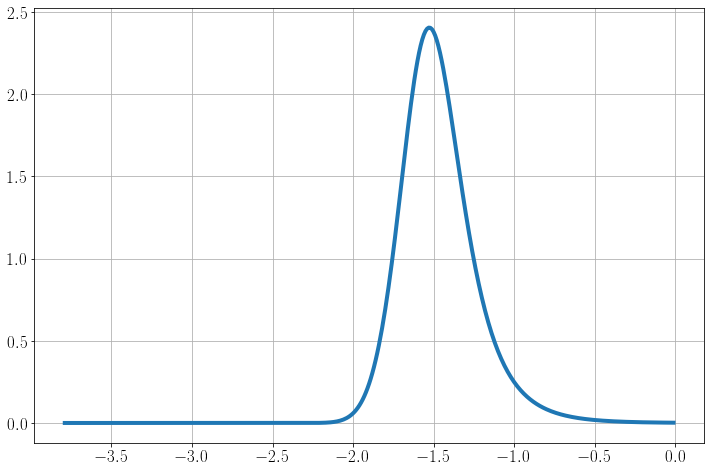

In [ ]:
U_arr =  [0, 0, 0, 0, 0.06463131507519854, 0.3832892301648289, 0.81035398312819, 0.9653022499322309, 1]
J_arr =  [0.4671215288625387, 0.1610471732413586, 0.09292714506948394, 0.06570355318275373, 0.0515190332875324, 0.04292128519020507, 0.0371787477122733, 0.03307692307692307, 0.03]
K_arr =  [0.4671215288625387, 0.1610471732413586, 0.09292714506948394, 0.06570355318275373, 0.0515190332875324, 0.04292128519020507, 0.0371787477122733, 0.03307692307692307, 0.03]
V_arr =  [3.31196040544157, 0.8600731642469739, 0.40964223204281247, 0.2526301643610369, 0.17618732751694133, 0.12356402131908403, 0.06672654361752858, 0.032185777536821183, 0.02]
count_arr =  [2, 3, 4, 5, 6, 7, 8, 9, 10]
D_arr =  [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
D = D_arr[0]
J = J_arr[0]
K = K_arr[0]
U = U_arr[0]
V = V_arr[0]

V = 0.019909015762077577
J = 0.015838964056748835
K = 0
U = 0

count = count_arr[0]
N = 2 * count
j = J * N
k = K * N
v = V * sqrt(N)
delta = sqrt(2*v**2 + U**2/4)
gamma = (3*j + k + 2*U)/(8*v)
Eg = -U/2 - 3*j/4 + v * (gamma - sqrt(gamma*2 + 4))
Eg *= 100
Cv = []
Ep = -U/2 - 3*j/4 + v * (gamma + sqrt(gamma*2 + 4))
Em = -U/2 - 3*j/4 + v * (gamma - sqrt(gamma*2 + 4))
csp = sqrt(sqrt(gamma**2 + 4) - gamma)/sqrt(2*sqrt(gamma**2 + 4))
csm = sqrt(sqrt(gamma**2 + 4) + gamma)/sqrt(2*sqrt(gamma**2 + 4))
ccp = csm
ccm = -csp
evals = np.array([k/4]*2 + [-U/4 + delta/2, -U/4 - delta/2] * 4 + [-U/2 + j/4]*3 + [-3*k/4] + [Ep, Em])
Trange = 10**np.arange(-4, 0, 0.01, dtype=float)
Gamma = []
for T in Trange:
    kB = 1
    beta = 1/(kB * T)
    Z = sum(np.exp(-evals * beta))
    # Zp = sum(evals * np.exp(-evals * beta))
    Cv_T = (sum(evals**2 * np.exp(-evals * beta)) / (Z * T**2) - (sum(evals * np.exp(-evals * beta)/(Z * T)))**2) / kB
    Cv.append(Cv_T)
    Gamma.append(Cv_T/T)
plt.plot(np.log10(Trange), Cv)
# plt.plot(np.log10(Trange), Gamma)
plt.show()

## Exact diagonalization of fixed-point Hamiltonian

In [3]:
def imp_energy(Ek_0, V, J, K, U):
    dim = len(Ek_0)
    ed = -U/2
    imp_ed_up = [create(2)*destroy(2), identity(2)]
    imp_ed_dn = [identity(2), create(2)*destroy(2)]
    imp_U = [create(2)*destroy(2), create(2)*destroy(2)]
    bath = [identity(2)]*2*dim
    return ed*tensor(imp_ed_up+bath) + ed*tensor(imp_ed_dn+bath) + U*tensor(imp_U+bath)


def kin_en(Ek_0, V, J, K, U):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        for sigma in ["u", "d"]:
            # print (i, sigma)
            imp = [identity(2)]*2
            bef = [identity(2)]*2*i
            tau = create(2)*destroy(2) - 1/2
            curr = [Ek_0[i]*tau, identity(2)] if sigma == "u" else [identity(2), Ek_0[i]*tau]
            aft = [identity(2)]*2*(dim - i - 1)
            mats = imp+bef+curr+aft
            H += tensor(mats)
    return H


def hyb(Ek_0, V, J, K, U):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        for sigma in ["u", "d"]:
            # print (i, sigma)
            tau = create(2)*destroy(2) - 1/2
            if sigma == "u":
                mats1 = [destroy(2), identity(2)] + [identity(2)]*2*i + [create(2), identity(2)] + [identity(2)]*2*(dim - i - 1)
                mats2 = [create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1)
            else:
                mats1 = [identity(2), destroy(2)] + [identity(2)]*2*i + [identity(2), create(2)] + [identity(2)]*2*(dim - i - 1)
                mats2 = [identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(dim - i - 1)
            H += -tensor(mats1) + tensor(mats2)
    return V * H
    
    
def spin(Ek_0, V, J, K, U):
    H = 0
    dim = len(Ek_0)
    idt = identity(2)
    Sdz = 0.5 * (tensor(create(2)*destroy(2), identity(2)) - tensor(identity(2), create(2)*destroy(2)))
    Sdplus = tensor(create(2), destroy(2))
    Sdmin = -tensor(destroy(2), create(2))
    Ksz = Ksplus = Ksmin = 0
    for i,j in product(range(dim), range(dim)):
        # print (i,j)
        if i < j:
            Ksz += 0.5 * tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [destroy(2), idt] + [idt]*2*(dim - j - 1))
            Ksz -= 0.5 * tensor([idt]*2*i + [idt, create(2)] + [idt]*2*(j - i - 1) + [idt, destroy(2)] + [idt]*2*(dim - j - 1))
            Ksplus += tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [idt, destroy(2)] + [idt]*2*(dim - j - 1))
            Ksmin += tensor([idt]*2*i + [idt, destroy(2)] + [idt]*2*(j - i - 1) + [create(2), idt] + [idt]*2*(dim - j - 1))
        elif i > j:
            Ksz -= 0.5 * tensor([idt]*2*j + [destroy(2), idt] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Ksz += 0.5 * tensor([idt]*2*j + [idt, destroy(2)] + [idt]*2*(i - j - 1) + [idt, create(2)] + [idt]*2*(dim - i - 1))
            Ksplus -= tensor([idt]*2*j + [idt, destroy(2)] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Ksmin -= tensor([idt]*2*j + [create(2), idt] + [idt]*2*(i - j - 1) + [idt, destroy(2)] + [idt]*2*(dim - i - 1))
        else:
            Ksz += 0.5 * tensor([idt]*2*i + [create(2)*destroy(2), idt] + [idt]*2*(dim - i - 1))
            Ksz -= 0.5 * tensor([idt]*2*i + [idt, create(2)*destroy(2)] + [idt]*2*(dim - i - 1))
            Ksplus += tensor([idt]*2*i + [create(2), destroy(2)] + [idt]*2*(dim - i - 1))
            Ksmin -= tensor([idt]*2*i + [destroy(2), create(2)] + [idt]*2*(dim - i - 1))

    return J * (tensor(Sdz, Ksz) + 0.5*tensor(Sdplus, Ksmin) + 0.5*tensor(Sdmin, Ksplus))


def charge(Ek_0, V, J, K, U):
    H = 0
    dim = len(Ek_0)
    idt = identity(2)
    Cdz = 0.5 * (tensor(create(2)*destroy(2), identity(2)) + tensor(identity(2), create(2)*destroy(2)) - 1)
    Cdplus = tensor(create(2), create(2))
    Cdmin = -tensor(destroy(2), destroy(2))
    Kcz = -dim/2
    Kcplus = Kcmin = 0
    for i,j in product(range(dim), range(dim)):
        # print (i,j)
        if i < j:
            Kcz += 0.5 * tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [destroy(2), idt] + [idt]*2*(dim - j - 1))
            Kcz += 0.5 * tensor([idt]*2*i + [idt, create(2)] + [idt]*2*(j - i - 1) + [idt, destroy(2)] + [idt]*2*(dim - j - 1))
            Kcplus += tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [idt, create(2)] + [idt]*2*(dim - j - 1))
            Kcmin += tensor([idt]*2*i + [idt, destroy(2)] + [idt]*2*(j - i - 1) + [destroy(2), idt] + [idt]*2*(dim - j - 1))
        elif i > j:
            Kcz -= 0.5 * tensor([idt]*2*j + [destroy(2), idt] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Kcz -= 0.5 * tensor([idt]*2*j + [idt, destroy(2)] + [idt]*2*(i - j - 1) + [idt, create(2)] + [idt]*2*(dim - i - 1))
            Kcplus -= tensor([idt]*2*j + [idt, create(2)] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Kcmin -= tensor([idt]*2*j + [destroy(2), idt] + [idt]*2*(i - j - 1) + [idt, destroy(2)] + [idt]*2*(dim - i - 1))
        else:
            Kcz += 0.5 * tensor([idt]*2*i + [create(2)*destroy(2), idt] + [idt]*2*(dim - i - 1))
            Kcz += 0.5 * tensor([idt]*2*i + [idt, create(2)*destroy(2)] + [idt]*2*(dim - i - 1))
            Kcplus += tensor([idt]*2*i + [create(2), create(2)] + [idt]*2*(dim - i - 1))
            Kcmin -= tensor([idt]*2*i + [destroy(2), destroy(2)] + [idt]*2*(dim - i - 1))

    return K * (tensor(Cdz, Kcz) + 0.5*tensor(Cdplus, Kcmin) + 0.5*tensor(Cdmin, Kcplus))

## Spectral Function

In [ ]:
def rho_at_w(args):
    [Em, Emp],[Xm,Xmp] = args
    cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    Vmmp = Xm.dag()*cdag_up*Xmp
    Vmmp_sq = np.real((Vmmp*Vmmp.dag())[0][0][0])
    x = w - Emp + Em
    eta = abs(max(Ek_0))      # width of broadening function
    return Vmmp_sq * exp(-(x/eta)**2)/(eta*sqrt(pi)) * (exp(-beta*Em) + exp(-beta*Emp)) / Z

Ek_0 = np.array([-0.1, 0.1])
# print (Ek_0)
U = 0
V = 0.019909015762077577
J = 0.015838964056748835
K = 0
plt.rcParams["figure.figsize"]= 12, 4
H = kin_en(Ek_0, V, J, K, U)
# H += imp_energy(Ek_0, V, J, K, U)
H += hyb(Ek_0, V, J, K, U)
H += spin(Ek_0, V, J, K, U)
H += charge(Ek_0, V, J, K, U)
H = 0.5 * (H + H.dag())
E, X = H.eigenstates()
# E = np.array(E)
T = 1
kb = 1
beta = 1/(kb*T)
Z = sum(np.exp(-beta*E))
w_range = np.arange(-1,1,0.05)
rho = []
for w in tqdm(w_range):
    rho_w = sum(Pool(processes=10).map(rho_at_w, zip(product(E, E), product(X, X))))
    rho.append(rho_w)
    # for [Em, Emp],[Xm,Xmp] in zip(product(E, E), product(X, X)):
    #     cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    #     Vmmp = Xm.dag()*cdag_up*Xmp
    #     Vmmp_sq = np.real((Vmmp*Vmmp.dag())[0][0][0])
    #     x = w - Emp + Em
    #     eta = Ek_0[-1]      # width of broadening function
    #     rho[-1] += Vmmp_sq * exp(-(x/w)**2)/(w*sqrt(pi)) * (exp(-beta*Em) + exp(-beta*Emp)) / Z    

plt.plot(w_range, rho)
plt.show()

## $C_v$ using these eigenvalues

In [15]:
Ek_0 = np.array([-0.2, -0.1, 0.1, 0.2])
# print (Ek_0)
U = 0
V = 0.019909015762077577
J = 0.015838964056748835
K = 0
plt.rcParams["figure.figsize"]= 12, 4
H = kin_en(Ek_0, V, J, K, U)
# H += imp_energy(Ek_0, V, J, K, U)
H += hyb(Ek_0, V, J, K, U)
H += spin(Ek_0, V, J, K, U)
H += charge(Ek_0, V, J, K, U)
# H = 0.5 * (H + H.dag())
evals = H.eigenstates()
print (evals[0][0], evals[1][0])
return
Trange = 10**np.arange(-4, 0.5, 0.01, dtype=float)
Cv_imp = []
Gamma = []
for T in Trange:
    kB = 1
    beta = 1/(kB * T)
    Z = sum(np.exp(-evals * beta))
    # Zp = sum(evals * np.exp(-evals * beta))
    Cv = (sum(evals**2 * np.exp(-evals * beta)) / (Z * T**2) - (sum(evals * np.exp(-evals * beta)/(Z * T)))**2) / kB
    Cv_0 = (sum(Ek_0**2 * np.exp(-Ek_0 * beta)) / (Z * T**2) - (sum(Ek_0 * np.exp(-Ek_0 * beta)/(Z * T)))**2) / kB
    Cv_imp.append(Cv - Cv_0)
    Gamma.append(Cv_imp[-1]/T)
print ("V=",V,"J=",J)
fig,ax = plt.subplots(1,2)
ax[0].plot(np.log10(Trange), Cv_imp)
# plt.show()
ax[1].plot(np.log10(Trange), Gamma)
plt.show()

(-0.5882669825159965-2.0398953894957502e-19j) Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (1024, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


SyntaxError: 'return' outside function (<ipython-input-15-6803f391f909>, line 16)